# 3.5 多変量時系列データの特徴把握と因果探索

## 3.5.2 相互相関係数によるアプローチ

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import statsmodels.api as sm

from graphviz import Digraph

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ


In [3]:
dataset_path = '../MMM.csv'
df = pd.read_csv(
    dataset_path,
    parse_dates=True,
    index_col='day')

df


,Sales,OfflineAD,OnlineAD
day,,,
2019-01-01,2421099.200,8.255520e+05,289099.200
2019-01-02,2893768.826,8.065540e+05,297668.826
2019-01-03,2667494.968,6.178813e+05,208972.890
2019-01-04,2016377.026,1.003793e+06,166375.482
2019-01-05,2511385.175,6.651360e+05,230455.368
...,...,...,...
2019-06-26,2373450.715,1.120225e+06,138594.564
2019-06-27,1860416.854,1.148680e+06,174731.142
2019-06-28,2546100.284,9.110840e+05,138329.496


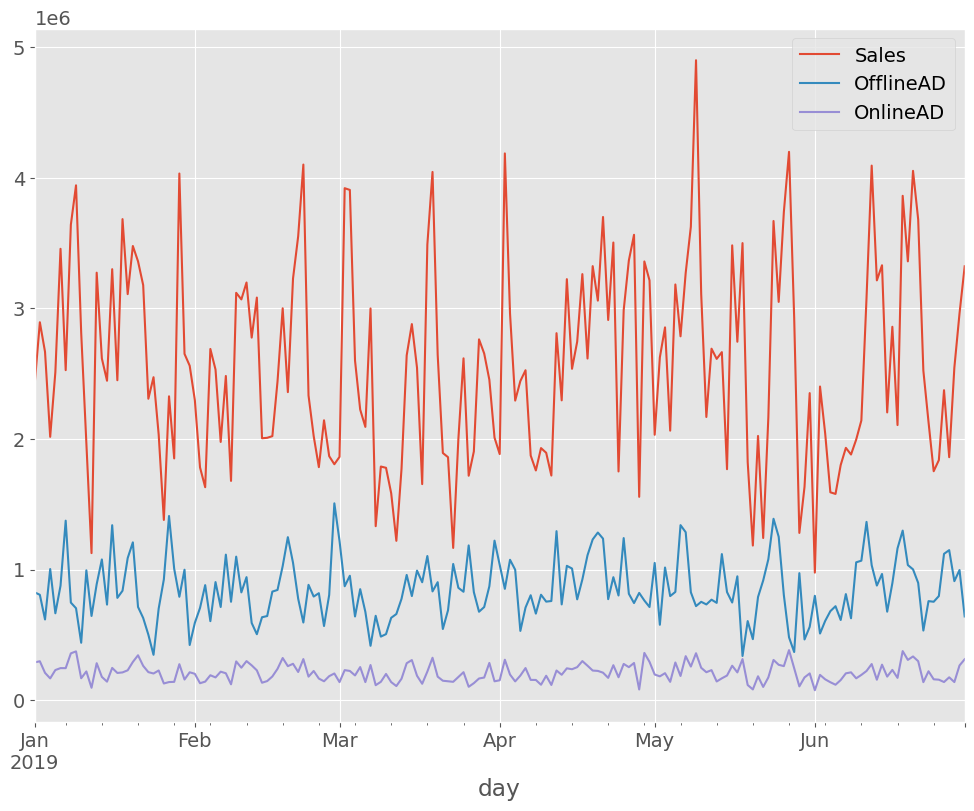

In [4]:
df.plot()
plt.show()


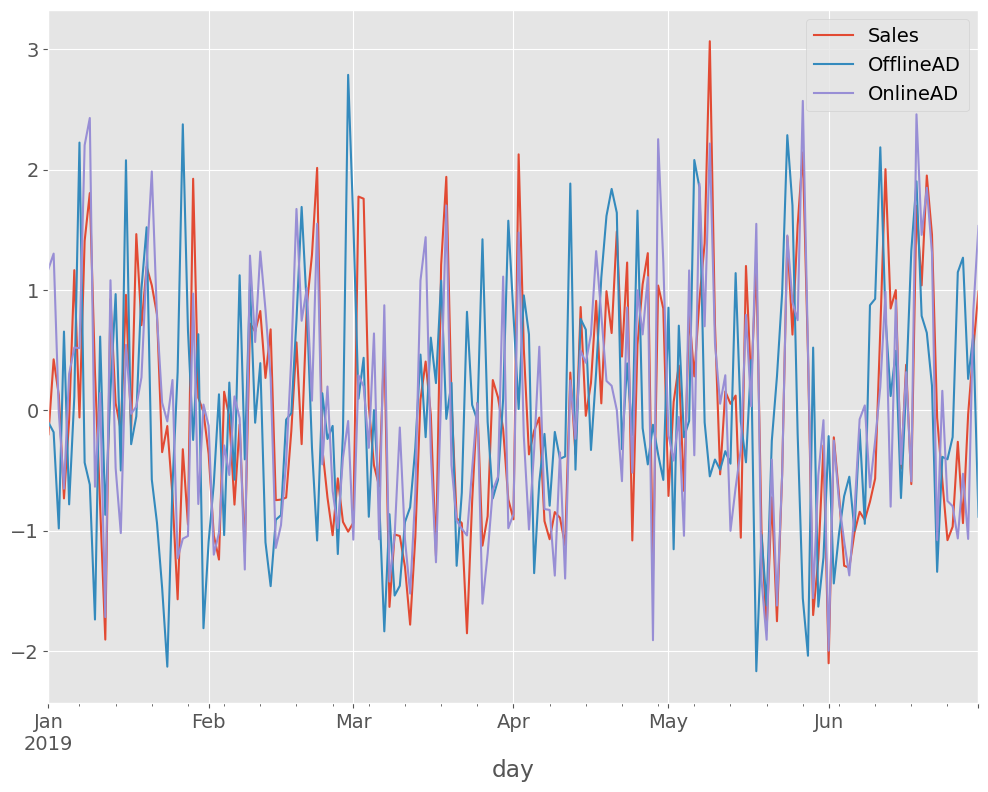

In [5]:
# 標準化（平均0，分散1）
df_std = stats.zscore(df)

df_std.plot()
plt.show()


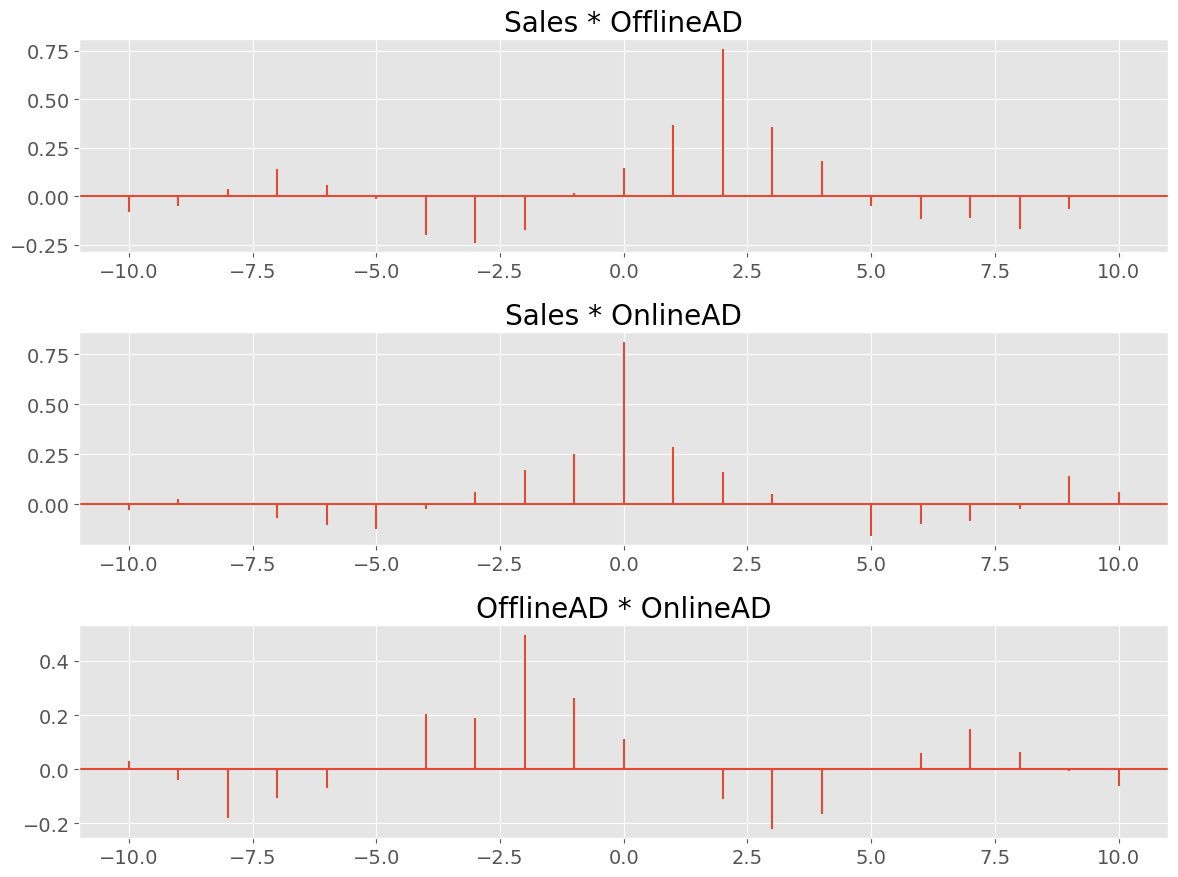

In [6]:
# 相互相関コレログラム

fig, ax = plt.subplots(3, 1)

# SalesとOfflineADの相互相関
ax[0].xcorr(df_std['Sales'], df_std['OfflineAD'])
ax[0].set_title('Sales * OfflineAD')

# SalesとOnlineADの相互相関
ax[1].xcorr(df_std['Sales'], df_std['OnlineAD'])
ax[1].set_title('Sales * OnlineAD')

# OfflineADとOnlineADの相互相関
ax[2].xcorr(df_std['OfflineAD'], df_std['OnlineAD'])
ax[2].set_title('OfflineAD * OnlineAD')

fig.tight_layout()
plt.show()


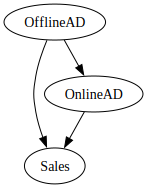

In [7]:
# 有向グラフ（先行系列＋一致系列）

# インスタンスの生成
graph = Digraph()

# ノードの追加
for i in df.columns:
    graph.node(i)
    
# エッジの追加
graph.edge('OfflineAD', 'Sales')
graph.edge('OfflineAD', 'OnlineAD')
graph.edge('OnlineAD', 'Sales')

# グラフの描画
graph


## 3.5.4 VAR(VectorAutoRegressive ベクトル自己回帰)で実施

In [8]:
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR

from graphviz import Digraph

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ


In [9]:
dataset='../MMM.csv' #データセットのファイル名
df = pd.read_csv(
    dataset,
    parse_dates=True,
    index_col='day')

print(df) #確認


                  Sales     OfflineAD    OnlineAD
day                                              
2019-01-01  2421099.200  8.255520e+05  289099.200
2019-01-02  2893768.826  8.065540e+05  297668.826
2019-01-03  2667494.968  6.178813e+05  208972.890
2019-01-04  2016377.026  1.003793e+06  166375.482
2019-01-05  2511385.175  6.651360e+05  230455.368
...                 ...           ...         ...
2019-06-26  2373450.715  1.120225e+06  138594.564
2019-06-27  1860416.854  1.148680e+06  174731.142
2019-06-28  2546100.284  9.110840e+05  138329.496
2019-06-29  2961440.424  9.963220e+05  265571.064
2019-06-30  3322232.779  6.408697e+05  313092.000

[181 rows x 3 columns]


### VARモデルで変数間の関係性を検討

#### 単位根検定
* Augmented Dickey-Fuller 単位根検定
  * 帰無仮説：単位根がある
  * 対立仮説：定数項＋定常過程

In [10]:
for col in df.columns:
    # 単位根検定
    c_results = adfuller(df[col], regression="c")
    # p値の表示
    print(col, '\t', c_results[1])


Sales 	 1.3316913900397309e-14
OfflineAD 	 4.264714578694423e-11
OnlineAD 	 1.6399421694391537e-08


#### VARモデルの構築

In [12]:
# VARモデルの構築

# 最大のラグ数
maxlags = 10

# モデルのインスタンス生成
var_model = VAR(df)

# 最適なラグの探索
lag = var_model.select_order(maxlags).selected_orders
print('最適なラグ：',lag['aic'],'\n')

# モデルの学習
results = var_model.fit(lag['aic'])

# 結果出力
print(results.summary())


最適なラグ： 3 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Mar, 2024
Time:                     21:26:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    72.4635
Nobs:                     178.000    HQIC:                   72.1447
Log likelihood:          -7129.24    FPE:                1.72885e+31
AIC:                      71.9272    Det(Omega_mle):     1.46739e+31
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const           -83731.484470    237565.067117           -0.352           0.724
L1.Sales             0.019934         0.121779            0.164           0.870
L1.OfflineAD         0.396654         0.168040       

#### グレンジャー因果性の検定

In [17]:
# グレンジャー因果性の検定
#   帰無仮説：グレンジャー因果なし
#   対立仮説：グレンジャー因果あり

for i, j in itertools.product(range(len(df.columns)), repeat=2):
    if i == j:
        continue
    # 因果の推定
    test_results = results.test_causality(causing=i, caused=j)
    # p値
    test_results.pvalue
    # 検定結果の表示
    print(df.columns[i], '->', df.columns[j], '\t', test_results.pvalue)
    


Sales -> OfflineAD 	 0.1468625798241679
Sales -> OnlineAD 	 0.7848913815447163
OfflineAD -> Sales 	 1.8937325083334636e-36
OfflineAD -> OnlineAD 	 4.839521581679368e-10
OnlineAD -> Sales 	 0.4299534534728544
OnlineAD -> OfflineAD 	 0.4788944144467945


OfflineAD -> Sales 	 1.8937325083334636e-36
OfflineAD -> OnlineAD 	 4.839521581679368e-10


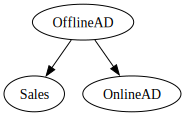

In [20]:
# 有向グラフ（VARのみ考慮）

# インスタンスの生成
graph = Digraph()

# グラフにノードを追加
for col in df.columns:
    graph.node(col)
    
# 因果を検定し優位なとき線をひく
for i, j in itertools.product(range(len(df.columns)), repeat=2):
    if i == j:
        continue
    test_results = results.test_causality(causing=i, caused=j)
    # p値が0.05未満のとき線を追加
    if test_results.pvalue < 0.05:
        graph.edge(df.columns[i], df.columns[j])
        print(df.columns[i], '->', df.columns[j], '\t', test_results.pvalue)
        
graph


#### インパルス応答関数（直交化）

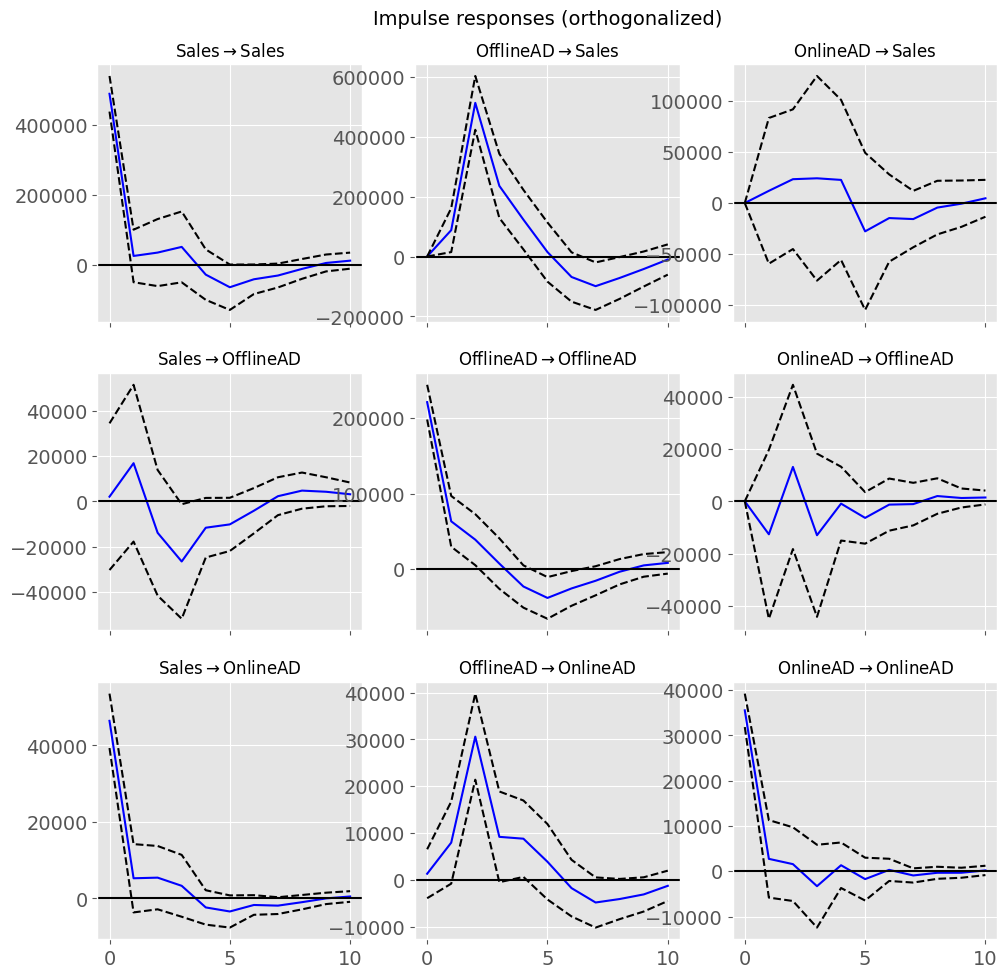

In [21]:
# インパルス応答関数(直交化)

irf = results.irf()
irf.plot(orth=True)
plt.show()


### SVARモデル

In [22]:
# SVARモデルの構築

#　目的変数の行列Aの定義
A_0 = np.array([[1, 'E','E'],
                ['E', 1,'E'], 
                ['E','E', 1]])

# モデルのインスタンス生成
SVAR_model = SVAR(df, svar_type='A', A=A_0)

# 学習
results = SVAR_model.fit(maxlags=3)

#　推定結果（目的変数の行列A）
results.A


array([[ 1.00000000e+00,  3.11122225e-02, -6.62109834e+00],
       [ 1.72367411e-02,  1.00000000e+00, -2.26620261e-01],
       [-9.51650234e-02, -5.87925896e-03,  1.00000000e+00]])

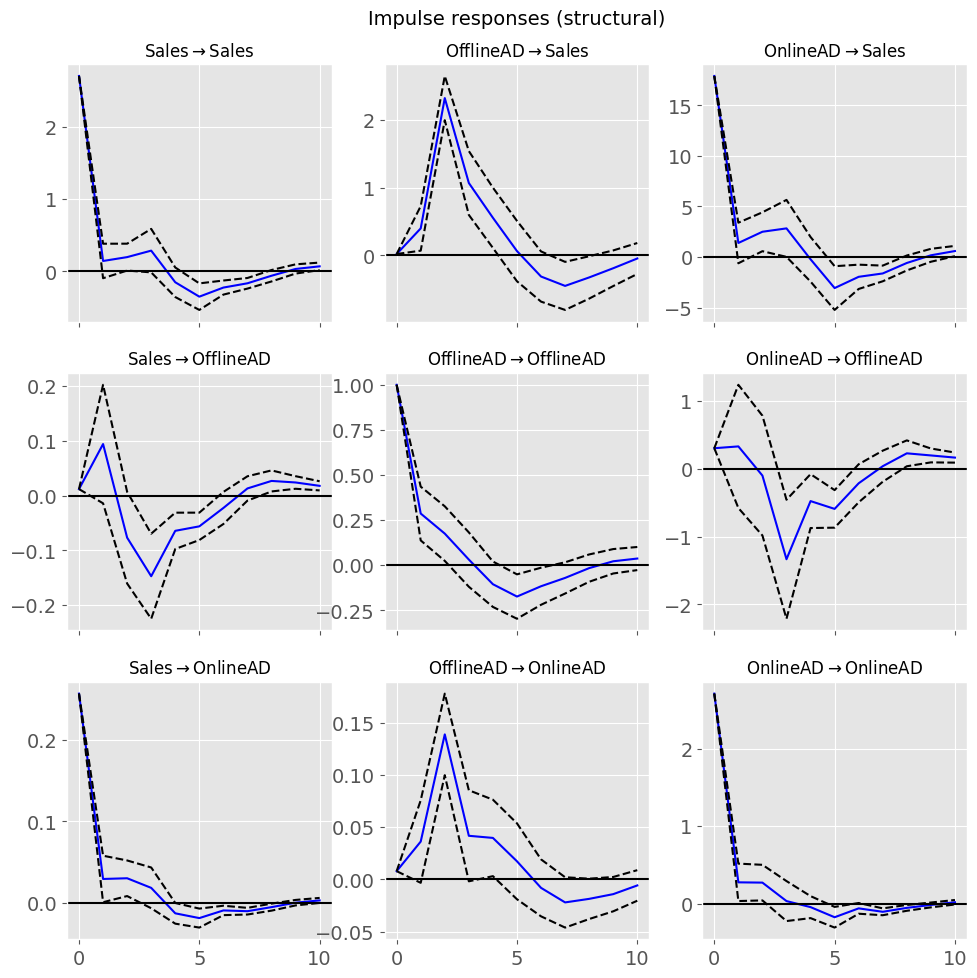

In [23]:
# インパルス応答関数(構造)

irf = results.irf()
irf.plot()
plt.show()


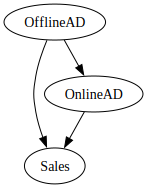

In [26]:
# 有向グラフ（VAR＋線形回帰）

graph = Digraph()

# ノードを追加
for i in range(len(df.columns)):
    graph.node(df.columns[i])

# 辺を追加
graph.edge(df.columns[1], df.columns[0])
graph.edge(df.columns[2], df.columns[0])
graph.edge(df.columns[1], df.columns[2])

# 画像を表示
graph
